In [1]:
import numpy as np

import os

from sklearn.model_selection import train_test_split



def load_data_from_npy_files(data_dir):

    X, y = [], []

    

    for file_name in os.listdir(data_dir):

        if file_name.endswith('.npy'):

            file_path = os.path.join(data_dir, file_name)

            data = np.load(file_path, allow_pickle=True).item()  # Load the .npy file

            

            frames = data['frames']

            label = data['label']

            

            # Append the frames and label to the lists

            X.append(frames)

            y.append(label)

    

    # Convert lists to numpy arrays

    X = np.array(X)

    y = np.array(y)

    

    return X, y



# Load training and testing data

train_data_dir = '/kaggle/input/ucf-annotation-videos32-frames/extracted_segments/train'

test_data_dir = '/kaggle/input/ucf-annotation-videos32-frames/extracted_segments/test'



X_train, y_train = load_data_from_npy_files(train_data_dir)

X_test, y_test = load_data_from_npy_files(test_data_dir)



# Split the training data into train/validation sets

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)



print(f"Training data shape: {X_train.shape}, Labels shape: {y_train.shape}")

print(f"Validation data shape: {X_val.shape}, Labels shape: {y_val.shape}")

print(f"Testing data shape: {X_test.shape}, Labels shape: {y_test.shape}")


Training data shape: (1431, 32, 64, 64, 3), Labels shape: (1431,)
Validation data shape: (358, 32, 64, 64, 3), Labels shape: (358,)
Testing data shape: (306, 32, 64, 64, 3), Labels shape: (306,)


In [2]:
# Count occurrences of values 1 and 0 in y_train, y_val, and y_test

train_zeros = np.count_nonzero(y_train == 0)

train_ones = np.count_nonzero(y_train == 1)

val_zeros = np.count_nonzero(y_val == 0)

val_ones = np.count_nonzero(y_val == 1)

test_zeros = np.count_nonzero(y_test == 0)

test_ones = np.count_nonzero(y_test == 1)



# Print counts

print(f"Training data - 0s: {train_zeros}, 1s: {train_ones}")

print(f"Validation data - 0s: {val_zeros}, 1s: {val_ones}")

print(f"Testing data - 0s: {test_zeros}, 1s: {test_ones}")

Training data - 0s: 633, 1s: 798
Validation data - 0s: 167, 1s: 191
Testing data - 0s: 150, 1s: 156


In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv3D, BatchNormalization, ReLU, MaxPooling3D, GlobalAveragePooling3D, Add, Dense
from tensorflow.keras.models import Model

# 3D Convolutional Block
def conv3d_block(x, filters, kernel_size=(3, 3, 3), strides=(1, 1, 1), padding='same'):
    """
    A convolutional block with Conv3D, BatchNormalization, and ReLU activation.
    
    Args:
        x (tensor): Input tensor to the block.
        filters (int): Number of filters for the Conv3D layer.
        kernel_size (tuple): The kernel size for the Conv3D layer.
        strides (tuple): The strides for the Conv3D layer.
        padding (str): The padding method for Conv3D layer.
    
    Returns:
        tensor: The output tensor after applying Conv3D, BatchNorm, and ReLU.
    """
    x = Conv3D(filters, kernel_size=kernel_size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

# Residual Block
def residual_block(x, filters, kernel_size=(3, 3, 3), strides=(1, 1, 1), padding='same'):
    """
    A residual block that adds the input to the output of the block.
    
    Args:
        x (tensor): Input tensor to the block.
        filters (int): Number of filters for the Conv3D layers.
        kernel_size (tuple): The kernel size for the Conv3D layers.
        strides (tuple): The strides for the Conv3D layers.
        padding (str): The padding method for Conv3D layers.
    
    Returns:
        tensor: The output tensor after adding the input to the output.
    """
    shortcut = x  # Save the input tensor for the residual connection
    
    # Apply 1x1x1 convolution to match the number of filters in the shortcut path
    if x.shape[-1] != filters:  # Only apply if the number of filters is different
        shortcut = Conv3D(filters, (1, 1, 1), padding='same')(shortcut)
    
    # First convolutional block
    x = conv3d_block(x, filters, kernel_size, strides, padding)
    
    # Second convolutional block
    x = conv3d_block(x, filters, kernel_size, strides, padding)
    
    # Add the shortcut (residual connection)
    x = Add()([x, shortcut])
    
    return x

# 3D ResNet Model for Feature Extraction
def build_3d_resnet_feature_extractor(input_shape=(32, 64, 64, 3)):
    """
    Build a 3D ResNet model for feature extraction.
    
    Args:
        input_shape (tuple): Shape of the input video segments (frames, height, width, channels).
        
    Returns:
        model (tf.keras.Model): The 3D ResNet feature extractor model.
    """
    inputs = Input(shape=input_shape)

    # Initial Conv3D Block
    x = conv3d_block(inputs, 64, kernel_size=(3, 3, 3), strides=(1, 1, 1))
    x = MaxPooling3D(pool_size=(1, 2, 2))(x)

    # Residual Blocks
    x = residual_block(x, 128)
    x = residual_block(x, 256)
    x = residual_block(x, 512)

    # Global Average Pooling (to reduce spatial dimensions)
    x = GlobalAveragePooling3D()(x)
    
    # Final dense layer for feature extraction (optional)
    x = Dense(4096, activation='relu')(x)  # Output a 4096-dimensional feature vector

    # Define the model (this model only extracts features, no classification)
    model = Model(inputs=inputs, outputs=x, name="3D_ResNet_Feature_Extractor")
    
    return model

import numpy as np

def extract_features_3d_resnet(video_segments, resnet_model):
    """
    Extract feature vectors from a batch of video segments using the 3D ResNet model.
    
    Args:
        video_segments (np.array): A batch of video segments, each with shape (frames, height, width, channels).
        resnet_model (tf.keras.Model): The pre-trained 3D ResNet model used for feature extraction.
    
    Returns:
        np.array: An array of feature vectors extracted from the video segments.
    """
    # Preprocess video segments and extract features
    features = []
    for segment in video_segments:
        segment = np.expand_dims(segment, axis=0)  # Add batch dimension (1, frames, height, width, channels)
        feature_vector = resnet_model.predict(segment)  # Extract feature vector using the ResNet model
        features.append(feature_vector.flatten())  # Flatten the feature vector for easier handling
    return np.array(features)


In [8]:
from tensorflow.keras.layers import Dense

from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping



# Build the 3D ResNet feature extractor model

resnet_feature_extractor = build_3d_resnet_feature_extractor(input_shape=(32, 64, 64, 3))

resnet_feature_extractor.summary()



# Extract features using 3D ResNet for training, validation, and test data

X_train_features_resnet = extract_features_3d_resnet(X_train, resnet_feature_extractor)

X_val_features_resnet = extract_features_3d_resnet(X_val, resnet_feature_extractor)

X_test_features_resnet = extract_features_3d_resnet(X_test, resnet_feature_extractor)


Model: "3D_ResNet_Feature_Extractor"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 64,    │          0 │ -                 │
│ (InputLayer)        │ 64, 3)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 32, 64,    │      5,248 │ input_layer[0][0] │
│                     │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 64,    │        256 │ conv3d[0][0]      │
│ (BatchNormalizatio… │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 32, 64,    │          0 │ batch_normalizat… │
│                     │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 32, 32,    │          0 │ re_lu[0][0]       │
│ (MaxPooling3D)      │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 32, 32,    │    221,312 │ max_pooling3d[0]… │
│                     │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv3d_2[0][0]    │
│ (BatchNormalizatio… │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 32, 32,    │    442,496 │ re_lu_1[0][0]     │
│                     │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv3d_3[0][0]    │
│ (BatchNormalizatio… │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 32, 32,    │      8,320 │ max_pooling3d[0]… │
│                     │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ re_lu_2[0][0],    │
│                     │ 32, 128)          │            │ conv3d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 32, 32,    │    884,992 │ add[0][0]         │
│                     │ 32, 256)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv3d_5[0][0]    │
│ (BatchNormalizatio… │ 32, 256)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32, 256)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_6 (Conv3D)   │ (None, 32, 32,    │  1,769,728 │ re_lu_3[0][0]   

 Total params: 16,223,232 (61.89 MB)

 Trainable params: 16,219,520 (61.87 MB)

 Non-trainable params: 3,712 (14.50 KB)

I0000 00:00:1731532361.774131     109 service.cc:145] XLA service 0x785c10003f20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731532361.774186     109 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731532361.774192     109 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


I0000 00:00:1731532366.780766     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

In [9]:
import numpy as np
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, Flatten, Dense, GlobalAveragePooling3D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Concatenate

def build_c3d_feature_extractor(input_shape=(32, 64, 64, 3)):
    inputs = Input(shape=input_shape)

    # 1st Conv3D Block
    x = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling3D(pool_size=(1, 2, 2))(x)

    # 2nd Conv3D Block
    x = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(x)
    x = MaxPooling3D(pool_size=(1, 2, 2))(x)

    # 3rd Conv3D Block
    x = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(x)
    x = MaxPooling3D(pool_size=(2, 2, 2))(x)

    # 4th Conv3D Block
    x = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(x)
    x = MaxPooling3D(pool_size=(2, 2, 2))(x)

    # Flatten to get feature vector
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    model = Model(inputs, x, name="C3D_Feature_Extractor")

    return model


def extract_features(video_segments, c3d_model):
    features = []
    for segment in video_segments:
        segment = np.expand_dims(segment, axis=0)
        feature_vector = c3d_model.predict(segment)
        features.append(feature_vector.flatten())
    return np.array(features)





In [10]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

c3d_feature_extractor = build_c3d_feature_extractor()
c3d_feature_extractor.summary()

X_train_features_c3d = extract_features(X_train, c3d_feature_extractor)
X_val_features_c3d = extract_features(X_val, c3d_feature_extractor)
X_test_features_c3d = extract_features(X_test, c3d_feature_extractor)

Model: "C3D_Feature_Extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 64, 64, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_10 (Conv3D)              │ (None, 32, 64, 64, 64) │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 32, 32, 32, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_11 (Conv3D)              │ (None, 32, 32, 32,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 32, 16, 16,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_12 (Conv3D)              │ (None, 32, 16, 16,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 16, 8, 8, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_13 (Conv3D)              │ (None, 16, 8, 8, 512)  │     3,539,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 8, 4, 4, 512)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │   268,439,552 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 273,090,560 (1.02 GB)

 Trainable params: 273,090,560 (1.02 GB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━

In [11]:

# Concatenate C3D and 3D ResNet features
X_train_combined = np.concatenate([X_train_features_c3d, X_train_features_resnet], axis=1)
X_val_combined = np.concatenate([X_val_features_c3d, X_val_features_resnet], axis=1)
X_test_combined = np.concatenate([X_test_features_c3d, X_test_features_resnet], axis=1)

print(X_train_combined.shape)  # Check the new shape of the combined feature vectors

X_train_features = X_train_combined
X_val_features = X_val_combined
X_test_features = X_test_combined


(1431, 8192)


In [12]:
# Step 2: Define the fully connected classifier
fc_classifier = Sequential([
Dense(512, activation='relu', input_shape=(X_train_features.shape[1],)),
Dense(256, activation='relu'),
Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
fc_classifier.compile(optimizer=Adam(learning_rate=0.001), 
loss='binary_crossentropy', 
metrics=['accuracy'])

checkpoint = ModelCheckpoint("models/c3d/c3d_resnet_model_3.keras", monitor='val_loss', save_best_only=True, verbose=1)

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Step 3: Train the classifier
feature_fc_history = fc_classifier.fit(X_train_features, y_train, epochs=20, batch_size=32, validation_data=(X_val_features, y_val), callbacks=[checkpoint, early_stop])

fc_classifier.save('models/c3d/c3d_resnet_model_3.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5404 - loss: 0.6939
Epoch 1: val_loss improved from inf to 0.69408, saving model to models/c3d/c3d_resnet_model_3.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.5408 - loss: 0.6939 - val_accuracy: 0.5335 - val_loss: 0.6941
Epoch 2/20
40/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5696 - loss: 0.6779
Epoch 2: val_loss improved from 0.69408 to 0.67474, saving model to models/c3d/c3d_resnet_model_3.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5696 - loss: 0.6782 - val_accuracy: 0.5335 - val_loss: 0.6747
Epoch 3/20
38/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5950 - loss: 0.6638
Epoch 3: val_loss improved from 0.67474 to 0.63580, saving model to models/c3d/c3d_resnet_model_3.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5952 - loss: 0.6626 - val_accuracy: 0.7039 - val_loss: 0.6358
Epoch 4/20
37/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6409 - loss: 0.6298
Epoch 4: 

In [15]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import average_precision_score

def quantify_evaluate(model, X_train, y_train, X_val, y_val, X_test, y_test):
    # Evaluate the model on training, validation, and test sets
    train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

    # Print the results
    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Collect loss and accuracy values
    loss_values = [train_loss, val_loss, test_loss]
    accuracy_values = [train_accuracy, val_accuracy, test_accuracy]

    # Plotting the results
    plt.figure(figsize=(14, 6))

    # Plot for loss values
    plt.subplot(1, 2, 1)
    plt.bar(['Train', 'Validation', 'Test'], loss_values, color=['skyblue', 'orange', 'green'])
    plt.title('Loss Comparison')
    plt.xlabel('Dataset')
    plt.ylabel('Loss')
    plt.ylim([0, max(loss_values) + 0.1])

    # Annotate loss bars
    for i, v in enumerate(loss_values):
        plt.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom')

    # Plot for accuracy values
    plt.subplot(1, 2, 2)
    plt.bar(['Train', 'Validation', 'Test'], accuracy_values, color=['skyblue', 'orange', 'green'])
    plt.title('Accuracy Comparison')
    plt.xlabel('Dataset')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1.0])

    # Annotate accuracy bars
    for i, v in enumerate(accuracy_values):
        plt.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
    return loss_values, accuracy_values

def plot_history(model_history):
    plt.figure(figsize=(12, 5))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(model_history.history['accuracy'], label='Train Accuracy')
    plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(model_history.history['loss'], label='Train Loss')
    plt.plot(model_history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Adjust layout
    plt.tight_layout()

    # Show the plots
    plt.show()

def calculate_metrics(y_true, y_pred_binary):
    """
    Calculate precision, recall, F1 score, and AUC.
    
    Parameters:
        y_true: Ground truth labels.
        y_pred_binary: Predicted labels (binary).
    
    Returns:
        tuple: Precision, Recall, F1-score, AUC
    """
    precision = precision_score(y_true, y_pred_binary)
    recall = recall_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    auc = roc_auc_score(y_true, y_pred_binary)
    return precision, recall, f1, auc

def mean_average_precision(y_true, y_pred_probs):
    """
    Calculate mean average precision (mAP).
    
    Parameters:
        y_true: Ground truth labels.
        y_pred_probs: Predicted probabilities for each sample.
    
    Returns:
        float: mAP score
    """
    return average_precision_score(y_true, y_pred_probs)

def calculate_iou(y_true, y_pred_binary):
    """
    Calculate Intersection over Union (IoU) for segmentation tasks.

    Parameters:
        y_true: Ground truth labels.
        y_pred_binary: Predicted labels (binary).

    Returns:
        float: IoU score
    """
    intersection = np.sum(np.logical_and(y_true == 1, y_pred_binary == 1))
    union = np.sum(np.logical_or(y_true == 1, y_pred_binary == 1))
    iou = intersection / float(union) if union != 0 else 0
    return iou

def evaluate_and_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, threshold = 0.5):
    """
    Evaluates the model on the training, validation, and test datasets,
    and plots the loss and accuracy for each. Also reports additional metrics like 
    precision, recall, f1-score, AUC, mAP, confusion matrix, and IOU.

    Parameters:
        model: Trained model to be evaluated.
        X_train, y_train: Training data and labels.
        X_val, y_val: Validation data and labels.
        X_test, y_test: Test data and labels.
    """
    # Evaluate the model on training, validation, and test sets
    train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

    # Get the predicted probabilities for the test data
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    # Convert probabilities to binary labels (using a threshold of 0.5)
    y_train_pred_binary = (y_train_pred > threshold).astype(int)
    y_val_pred_binary = (y_val_pred > threshold).astype(int)
    y_test_pred_binary = (y_test_pred > threshold).astype(int)

    # Calculate additional performance metrics
    train_precision, train_recall, train_f1, train_auc = calculate_metrics(y_train, y_train_pred_binary)
    val_precision, val_recall, val_f1, val_auc = calculate_metrics(y_val, y_val_pred_binary)
    test_precision, test_recall, test_f1, test_auc = calculate_metrics(y_test, y_test_pred_binary)

    # Calculate mAP score for each dataset
    train_map = mean_average_precision(y_train, y_train_pred)
    val_map = mean_average_precision(y_val, y_val_pred)
    test_map = mean_average_precision(y_test, y_test_pred)

    # Calculate IoU for train, validation, and test sets
    train_iou = calculate_iou(y_train, y_train_pred_binary)
    val_iou = calculate_iou(y_val, y_val_pred_binary)
    test_iou = calculate_iou(y_test, y_test_pred_binary)

    # Create a dataframe to display the metrics in table format
    metrics = {
        "Dataset": ["Training", "Validation", "Test"],
        "Loss": [train_loss, val_loss, test_loss],
        "Accuracy": [train_accuracy, val_accuracy, test_accuracy],
        "Precision": [train_precision, val_precision, test_precision],
        "Recall": [train_recall, val_recall, test_recall],
        "F1-Score": [train_f1, val_f1, test_f1],
        "AUC": [train_auc, val_auc, test_auc],
        "mAP": [train_map, val_map, test_map],
        "IoU": [train_iou, val_iou, test_iou]  # Adding IoU to the metrics table
    }
    
    df_metrics = pd.DataFrame(metrics)
    print(df_metrics)
    
    # Find best IoU across all datasets
    best_iou = max(train_iou, val_iou, test_iou)
    print(f"Best IoU: {best_iou:.4f}")
    
    # Plotting the results
    loss_values = [train_loss, val_loss, test_loss]
    accuracy_values = [train_accuracy, val_accuracy, test_accuracy]

    # Plot for loss values
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.bar(['Train', 'Validation', 'Test'], loss_values, color=['skyblue', 'orange', 'green'])
    plt.title('Loss Comparison')
    plt.xlabel('Dataset')
    plt.ylabel('Loss')
    plt.ylim([0, max(loss_values) + 0.1])

    # Annotate loss bars
    for i, v in enumerate(loss_values):
        plt.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom')

    # Plot for accuracy values
    plt.subplot(1, 2, 2)
    plt.bar(['Train', 'Validation', 'Test'], accuracy_values, color=['skyblue', 'orange', 'green'])
    plt.title('Accuracy Comparison')
    plt.xlabel('Dataset')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1.0])

    # Annotate accuracy bars
    for i, v in enumerate(accuracy_values):
        plt.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Confusion Matrix Function
    def plot_confusion_matrix(y_true, y_pred_binary, dataset_name):
        cm = confusion_matrix(y_true, y_pred_binary)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues')
        plt.title(f'Confusion Matrix for {dataset_name} Dataset')
        plt.show()

    # Plot confusion matrices
    plot_confusion_matrix(y_train, y_train_pred_binary, "Training")
    plot_confusion_matrix(y_val, y_val_pred_binary, "Validation")
    plot_confusion_matrix(y_test, y_test_pred_binary, "Test")

    # AUC Curve Plotting
    def plot_roc_curve(fpr, tpr, auc_score, label):
        plt.plot(fpr, tpr, label=f'{label} (AUC = {auc_score:.2f})')

    # ROC Curve for training, validation, and test sets
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)

    train_auc = auc(fpr_train, tpr_train)
    val_auc = auc(fpr_val, tpr_val)
    test_auc = auc(fpr_test, tpr_test)

    plt.figure(figsize=(8, 6))
    plot_roc_curve(fpr_train, tpr_train, train_auc, 'Training')
    plot_roc_curve(fpr_val, tpr_val, val_auc, 'Validation')
    plot_roc_curve(fpr_test, tpr_test, test_auc, 'Test')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random classifier line
    plt.title('ROC Curve Comparison')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()




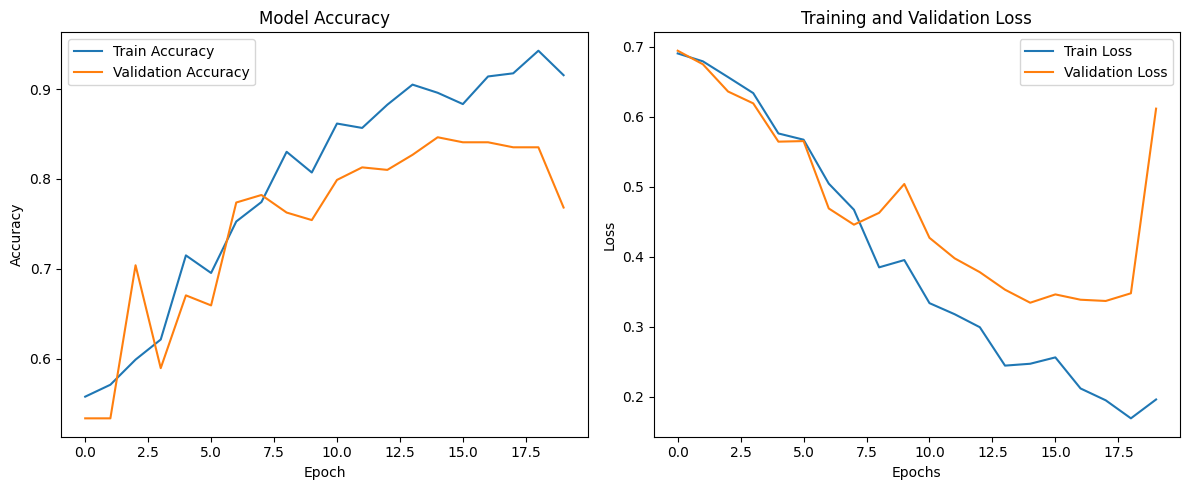

In [18]:
# from utils.plots import plot_history, evaluate_and_plot



plot_history(feature_fc_history)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
      Dataset      Loss  Accuracy  Precision    Recall  F1-Score       AUC  \
0    Training  0.330532  0.837876   0.998239  0.710526  0.830161  0.854473   
1  Validation  0.611334  0.768156   0.990909  0.570681  0.724252  0.782346   
2        Test  0.567890  0.774510   0.948454  0.589744  0.727273  0.778205   

        mAP       IoU  
0  0.995612  0.301878  
1  0.950285  0.242196  
2  0.931075  0.242944  
Best IoU: 0.3019


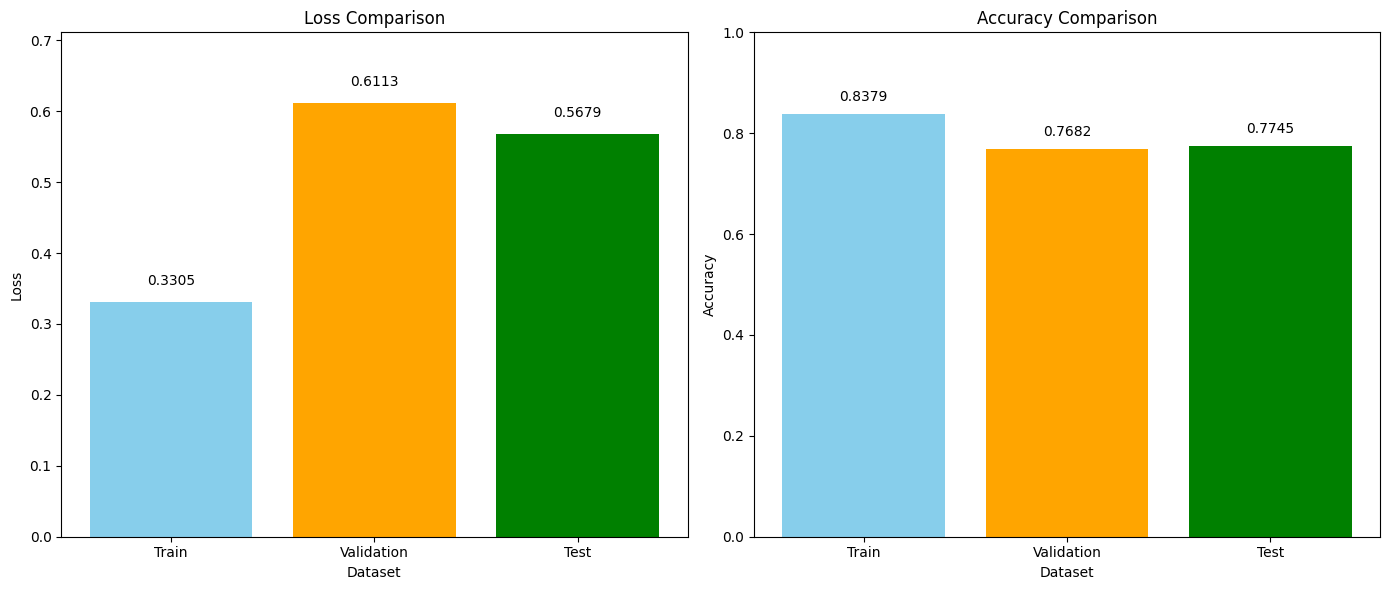

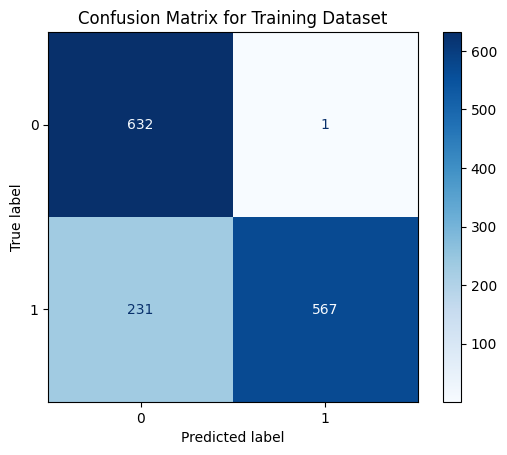

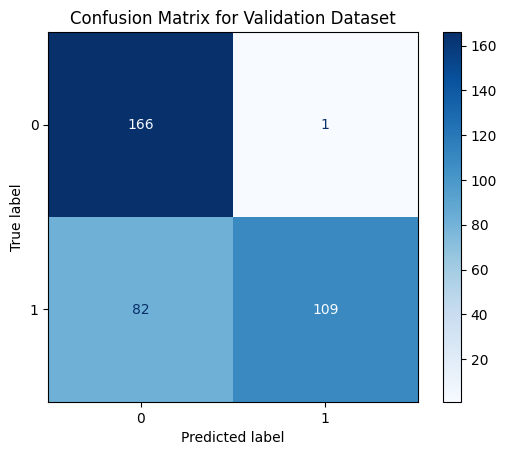

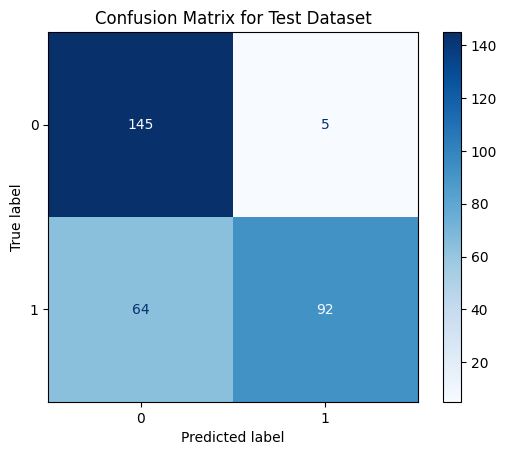

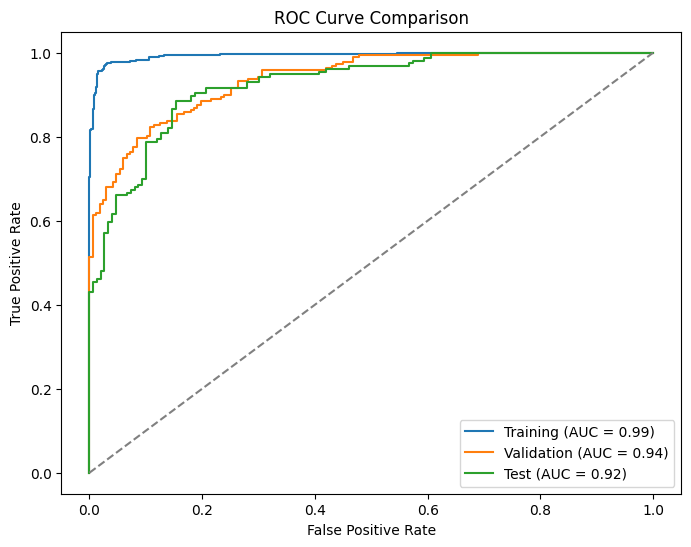

In [19]:
evaluate_and_plot(fc_classifier, X_train_features, y_train, X_val_features, y_val, X_test_features, y_test)